In [ ]:
!pip install chart_studio

In [4]:
import chart_studio.plotly as py

In [5]:
import warnings
warnings.filterwarnings('ignore')



import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk

from collections import defaultdict
from collections import Counter

# import keras
# from keras.models import Sequential
# from keras.initializers import Constant
# from keras.layers import LSTM, Embedding,BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers.embeddings import Embedding
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras.optimizers import Adam

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score


In [6]:
# Defining the global variables for the color schemes we will incorporate
pblue = "#496595"
pb2 = "#85a1c1"
pb3 = "#3f4d63"
pg = "#c6ccd8"
pb = "#202022"
pbg = "#f4f0ea"

pgreen = px.colors.qualitative.Plotly[2]

In [7]:
# read the data
df = pd.read_csv('election_data.csv')
df.head()

,clean_text,category
0,LG election waste time.APC win local govt gove...,not spam
1,Local government elections predictable electio...,not spam
2,A former Deputy Governor 's Central Bank said ...,not spam
3,I Do n't Fear Anybody You Only Die Once Govern...,not spam
4,There SELECTION Lagos today ... mean Local gov...,not spam


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  3641 non-null   object
 1   category    3642 non-null   object
dtypes: object(2)
memory usage: 57.0+ KB


In [9]:
df.isna().sum()

clean_text    1
category      0
dtype: int64

In [10]:
df.shape

(3642, 2)

In [11]:
df.dropna(subset=['clean_text'], inplace=True)
df.head()

,clean_text,category
0,LG election waste time.APC win local govt gove...,not spam
1,Local government elections predictable electio...,not spam
2,A former Deputy Governor 's Central Bank said ...,not spam
3,I Do n't Fear Anybody You Only Die Once Govern...,not spam
4,There SELECTION Lagos today ... mean Local gov...,not spam


In [12]:
# Finding maximum length of text message

np.max(df['clean_text'].apply(lambda x: len(x.split())).values)

50

### Exploratory Data Analysis

In [13]:
# Checking balance of dataset
grouped_df = df.groupby('category').count().values.flatten()
grouped_df

array([2894,  747])

In [14]:
fig = go.Figure()

fig.add_trace(go.Bar(
        x=['not spam'],
        y=[grouped_df[0]],
        name='Safe',
        text=[grouped_df[0]],
        textposition='auto',
        marker_color=pblue
)
             )
fig.add_trace(go.Bar(
        x=['spam'],
        y=[grouped_df[1]],
        name='Spam',
        text=[grouped_df[1]],
        textposition='auto',
        marker_color=pg
))

fig.update_layout(
    title='Class distribution in the dataset')

fig.show()



In [15]:
# Creating series with length as index
# Sorting the series by index i.e. length
len_df_ham = df[df['category']=='not spam'].clean_text.apply(lambda x: len(x.split())).value_counts().sort_index()
len_df_spam = df[df['category']=='spam'].clean_text.apply(lambda x: len(x.split())).value_counts().sort_index()

In [16]:
# X-axis consists of the length of the msgs
# Y-axis consists of the frequency of those lengths

fig = go.Figure()
fig.add_trace(go.Scatter(
x=len_df_ham.index,
y=len_df_ham.values,
name='Safe',
fill='tozeroy',
marker_color=pblue))

fig.add_trace(go.Scatter(
x=len_df_spam.index,
y=len_df_spam.values,
name='Spam',
fill='tozeroy',
marker_color=pg
))

fig.update_layout(
    title='Frequency of Tweets lengths')
fig.update_xaxes(range=[0, 80])
fig.show()
# py.iplot(fig, filename='jupyter-tweets')

In [17]:
def cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
df['clean_text'] = df['clean_text'].apply(cleaning)

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# Removing stop words
stop_words = stopwords.words('english')
more = ['u', 'im', 'c']
stop_words = stop_words + more


def sw_rem(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['clean_text'] = df['clean_text'].apply(sw_rem)




    Stemming - Omits the ends of words to achieve the goal correctly, this works most of the times and can also remove the derivational suffix

    Lemmatization - Working with a vocabulary and morphological analysis of words, removing inflectional endings only and returning the base and dictionary form of a word.

As we do not require much emphasis on words, we will focus more on stemming than lemmatization,.

Stemming algorithms

We have multiple algorithms to achieve our stemming goals, some of them are as follows:

    PorterStemmer - Fast and efficient. Strips off the end (suffix) to produce the stems. It does not follow linguistics but rather a set of 05 rules for diferent cases.

    SnowballStemmer - Generate a set of rules for any language. These are useful for non-english stemming tasks.

    LancasterStemmer - Iterative algorithm, uses about 120 rules, it tries to find an applicable rule by the last character of each word. The last character may be omitted or replaced.


In [21]:
stems = nltk.SnowballStemmer('english')

def stemming(text):
    text = ' '.join(stems.stem(word) for word in text.split())
    return text

In [22]:
df['clean_text'] = df['clean_text'].apply(stemming)
df.head()

,clean_text,category
0,lg elect wast timeapc win local govt governor ...,not spam
1,local govern elect predict elect nigeria resul...,not spam
2,former deputi governor central bank said milli...,not spam
3,nt fear anybodi die governor wike want violenc...,not spam
4,select lago today mean local govt elect nigeri...,not spam


In [23]:
# Creating a pipeline

def pipeline(text):
    text = cleaning(text)
    text = ' ' .join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(stems.stem(word) for word in text.split(' '))
    return text

In [24]:
df['clean_text'] = df['clean_text'].apply(pipeline)

In [25]:
# Encoding the categorical target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['category'])

df['label_num'] = le.transform(df['category'])
df.head()


,clean_text,category,label_num
0,lg elect wast timeapc win local govt governor ...,not spam,0
1,local govern elect predict elect nigeria resul...,not spam,0
2,former deputi governor central bank said milli...,not spam,0
3,nt fear anybodi die governor wike want violenc...,not spam,0
4,select lago today mean local govt elect nigeri...,not spam,0


In [ ]:
# Extracting the twitter word cloud mask
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(background_color='white', max_words=200, mask=twitter_mask)

wc.generate(' '.join(text for text in df[df['label']=='ham'].text))
plt.figure(figsize=(15, 10))
plt.title('Top words for safe messages', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Extracting the twitter word cloud mask
wc = WordCloud(background_color='white', max_words=200, mask=twitter_mask)

wc.generate(' '.join(text for text in df[df['label']=='spam'].text))
plt.figure(figsize=(15, 10))
plt.title('Top words for Spam messages', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()


Vectorization

We currently have each text record in string format. We need to convert each of those records into a vector that our models can work with. We will first do this using the bag-of-words model.

We will use two major approaches here

    CountVectorizer - Working on frequency of each word in the given string.

    Term frequency-inverse document frqeuency TFIDF - Works on frequency divided by the appearance of the given word in the total documents.



In [26]:
x = df['clean_text']
y = df['label_num']

len(x), len(y)

(3641, 3641)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=201)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

2184 2184
1457 1457


## Applying Oversampling

In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [29]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

In [30]:
# First working with count vectorizer

from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
count = CountVectorizer(stop_words='english', ngram_range=(1,1), min_df=0.1, max_df=0.7, max_features=130 )
count.fit(x)

x_train_num = count.transform(x_train)
x_test_num = count.transform(x_test)

# transform the dataset
X_train_resample, y_train_resample = pipeline.fit_resample(x_train_num, y_train)


In [31]:
x_train_num.shape

(2184, 7)



The CountVectorizer model can be tuned in a variety of ways:

    Stop words - Extremely common words can be omitted by the model by setting this parameter to the language corresponding to the text.

    ngram_range - It pairs up words together as features. If we consider bigrams and we have a sentence "I am happy", we will have two features - ["I am", "am happy"]. We can define a range of ngrams, so if we have the same sentence with a range from 1 to 2, our features will be: ["I", "am", "happy", "I am", "am happy"]. This increase is features helps to fine tune the model.

    min_df, max_df - Minimum and maximum frequencies of words of n-grams that can be used as features. If either of the conditions are not met, the feature will be omitted.

    max_features - Choose the most frequent words and drop everything else.



In [ ]:
# Example of a tuned model
count_tuned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=130)


In [32]:
# Working with TF-IDF now
from sklearn.feature_extraction.text import TfidfTransformer
# We are using transformer here
# If we use vectorizer, we can directly use the text
tfidf = TfidfTransformer()

tfidf.fit(X_train_resample)
x_train_tfidf = tfidf.transform(X_train_resample)

x_train_tfidf

<3482x7 sparse matrix of type '<class 'numpy.float64'>'
	with 3932 stored elements in Compressed Sparse Row format>

In [ ]:
text = df['clean_text']
label = df['label_num']

In [ ]:
# Calculating the total vocabulary
tk = Tokenizer()
tk.fit_on_texts(text)

vocab = len(tk.word_index)+1
vocab

6294

In [33]:
# Maximum length
max_len = np.max(df['clean_text'].apply(lambda x: len(x.split())).values)
max_len

39

In [ ]:
def embedding(text):
    return tk.texts_to_sequences(text)

train_padded = pad_sequences(embedding(text), max_len, padding='post')
train_padded


array([[  18,    1,  126, ...,    0,    0,    0],
       [  10,   11,    1, ...,    0,    0,    0],
       [ 539, 1405,   92, ...,    0,    0,    0],
       ...,
       [1067,   40, 3377, ...,    0,    0,    0],
       [ 683,   20,  410, ...,    0,    0,    0],
       [  29,   99,  137, ...,    0,    0,    0]], dtype=int32)


GloVe Embeddings

These embeddings are based on the principle that we can derive sematic relationships between words from their co-occurence matrix. This embedding focuses on words co-occurrences over the whole corpus.

They are a form of word representation that try to merge human understanding of languages into their structure. They have a learned representation in an n-dimension space, where words with similar meanings have similar embeddings. Two similar words are represented by almost similar vectors that are at a small distance in the vector space.

When using a vector space, all the words are represented as vectors in a predefined N-dimension vector space. Each word is mapped to a vector and the vector values are learned in a way that resembles a neural network.


In [ ]:
# Using our helper functions for GloVe

embedding_dict = dict()
embedding_dim = 100

# Each word is represented in one line in the text file
# Format - Word val1 val2 val3......val-n for n-dimension vector space

with open('../input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector = np.asarray(records[1:], dtype='float32')
        embedding_dict[word] = vector

In [ ]:
# Creating a matrix for each word as index (word numerical value extracted from tokenizer
# with N-features (corresponding to GloVe)
# We will replace the matrix elements by the words and their embeddings

# Our embeddings will also consist embeddings for padding
embedding_matrix = np.zeros((vocab, embedding_dim))

for word, index in tk.word_index.items():
    embed_vector = embedding_dict.get(word)
    if embed_vector is not None:
        embedding_matrix[index] = embed_vector
        
embedding_matrix

In [34]:
# We will be creating seaborn and plotly confusion matrices
import plotly.figure_factory as ff
x_axes = ['Safe','Spam']
y_axes = ['Spam', 'Safe']

def conf_matrix(z, x=x_axes, y=y_axes):
    z = np.flip(z, 0)
    # Change each element of z to string 
    # This allows them to be used as annotations
    z_str = [[str(y) for y in x] for x in z]
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_str)
    
    fig.update_layout(title_text='Confusion matrix', xaxis=dict(title='Predicted Value'),
                     yaxis=dict(title='Real value'))
    
    fig['data'][0]['showscale'] = True
    return fig

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [36]:
from sklearn.metrics import confusion_matrix
categories=['Safe', 'Spam']

def seaborn_conf(y, ypred):
    y_true = ["Not-Spam", "Spam"]
    y_pred = ["Not-Spam", "Spam"]
    # labels = ['True Neg','False Pos','False Neg','True Pos']
    # group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    # group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    # labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    # zip(group_names,group_counts,group_percentages)]labels = np.asarray(labels).reshape(2,2)

    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', vmin=0, vmax=1,)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()



## Model creation and prediction

We will first start with the naive bayes classifier which comes from a family of simple "probabilistic classifiers" based on application of Bayes theroem with strong independent assumptions between features.

The model is highly scalable, with number of parameters being linear with number of variables.


In [37]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model - CountVectorizer model
nb.fit(X_train_resample, y_train_resample)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
# Class and probability predictions
yp_class = nb.predict(x_test_num)
yp_prob = nb.predict_proba(x_test_num)[:, 1]

3 Gram Spam Detection Model
Accuracy 0.9787234042553191


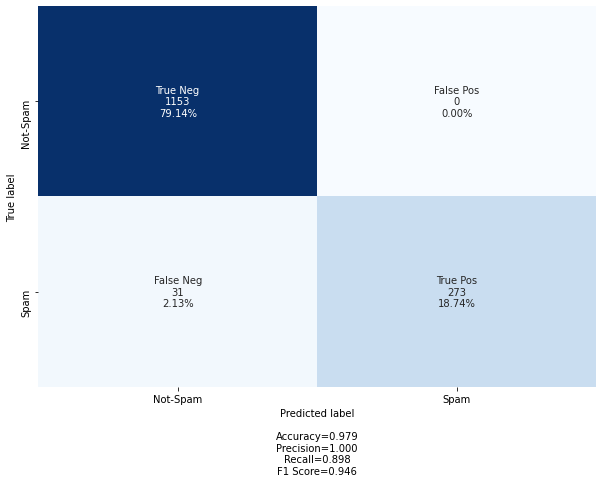

In [72]:
from sklearn import metrics
print('3 Gram Spam Detection Model')
print("Accuracy", metrics.accuracy_score(y_test, yp_class))
# seaborn_conf(y_test, yp_class)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ["Not-Spam", "Spam"]
cf = confusion_matrix(y_test, yp_class)
make_confusion_matrix(cf, figsize=(10,7), cbar=False, group_names=labels, categories=categories)


In [40]:
metrics.roc_auc_score(y_test, yp_prob)

0.8217635915460813

In [ ]:
import pickle

pickle.dump(nb, open('model.pkl', 'wb'))

Naive Bayes + Tfidf

In [69]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

0.9787234042553191


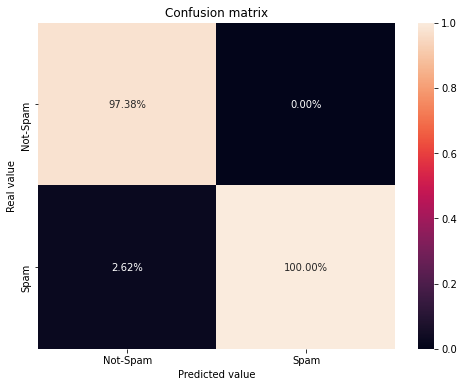

In [70]:
pipe.fit(x_train, y_train)
yp_class = pipe.predict(x_test)
print(metrics.accuracy_score(y_test, yp_class))
seaborn_conf(y_test, yp_class)

XGBoost

In [ ]:
import xgboost as xgb
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=6,
        n_estimators=200,
        use_label_encoder=False,
        eval_metric='auc'
    ))
    ]
)

Training accuracy score: 0.9922161172161172
Testing accuracy score: 0.9855868222374743


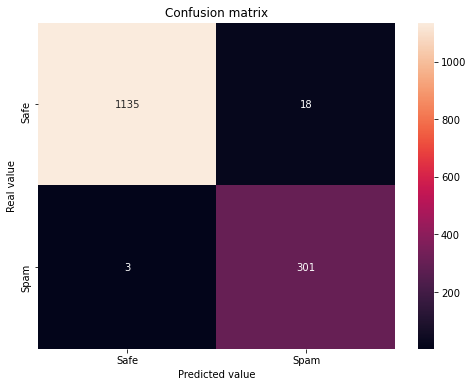

In [ ]:
pipe.fit(x_train, y_train)
yp_class_test = pipe.predict(x_test)
yp_class_train = pipe.predict(x_train)

print('Training accuracy score: {}'.format(metrics.accuracy_score(y_train, yp_class_train)))
print('Testing accuracy score: {}'.format(metrics.accuracy_score(y_test, yp_class_test)))

seaborn_conf(y_test, yp_class_test)

GLove Embedding

In [ ]:
train_padded.shape

(3641, 39)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_padded, label, test_size=0.2)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                   output_dim=embedding_matrix.shape[1],
                   weights=[embedding_matrix],
                   input_length=max_len
                   )
         )
model.add(Bidirectional(LSTM(max_len, return_sequences=True, recurrent_dropout=0.15)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Defining Callbacks
# Checkpoints in case our model stops training due to some circumstance - saving progress
checkpoints = ModelCheckpoint('ck_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
# Reducing the learning rate if no improvement in validation loss over 5 epochs
# This is to train the model better
reduce_lr = ReduceLROnPlateau(monitor='val_loss', vactor=0.1, verbose=1, patience=5, min_lr=0.0001)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1, callbacks=[reduce_lr, checkpoints])

In [ ]:
# Plotting the results
def learning_curve(history, arr):
    fig, ax=plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]])
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel('Value')
        ax[idx].set_title(arr[idx][0]+' X '+ arr[idx][1])

In [ ]:
learning_curve(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [ ]:
yp = (model.predict(x_test)>0.5).astype('int32')

In [ ]:
seaborn_conf(y_test, yp)